Epoch 1, Loss: 32.8653
Epoch 2, Loss: 25.1292
Epoch 3, Loss: 19.3426
Epoch 4, Loss: 16.1415
Epoch 5, Loss: 16.2543
Epoch 6, Loss: 11.6087
Epoch 7, Loss: 10.0463
Epoch 8, Loss: 11.3967
Epoch 9, Loss: 7.5004
Epoch 10, Loss: 7.4480
Epoch 11, Loss: 5.2858
Epoch 12, Loss: 4.4465
Epoch 13, Loss: 5.0749
Epoch 14, Loss: 3.8407
Epoch 15, Loss: 3.3334
Epoch 16, Loss: 2.9560
Epoch 17, Loss: 3.3939
Epoch 18, Loss: 3.7714
Epoch 19, Loss: 2.6595
Epoch 20, Loss: 2.4330
Epoch 21, Loss: 2.2227
Epoch 22, Loss: 1.5483
Epoch 23, Loss: 1.6604
Epoch 24, Loss: 2.4624
Epoch 25, Loss: 2.3472
Epoch 26, Loss: 1.3216
Epoch 27, Loss: 1.4430
Epoch 28, Loss: 2.9360
Epoch 29, Loss: 1.5676
Epoch 30, Loss: 2.3779


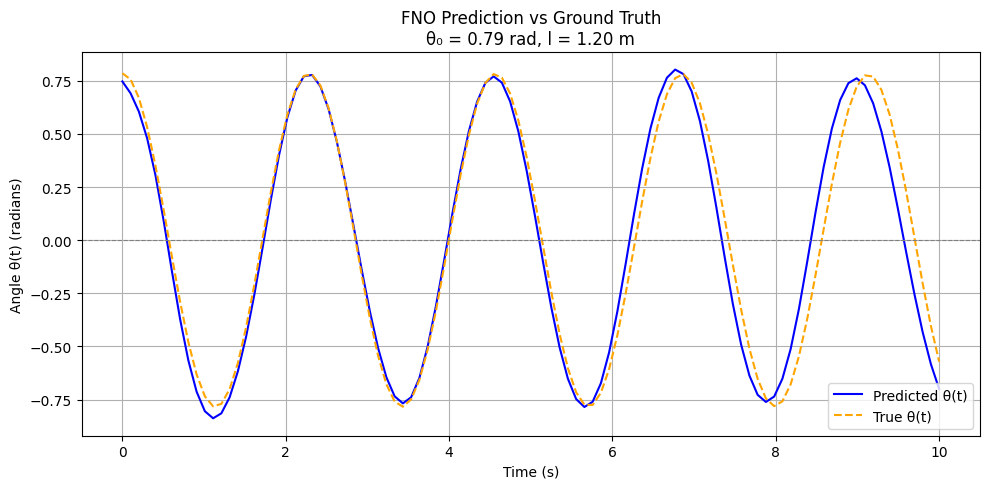

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Generate Data for a simple pendulum system
def pendulum_rhs(t, y, g, L):
    theta, omega = y
    return [omega, -g/L * np.sin(theta)]

# Function to generate pendulum trajectory given initial angle and length
def generate_trajectory(theta0, L, t_eval, g=9.81):
    sol = solve_ivp(
        fun=lambda t, y: pendulum_rhs(t, y, g, L),
        t_span=(t_eval[0], t_eval[-1]),
        y0=[theta0, 0.0],
        t_eval=t_eval,
        method='RK45'
    )
    return sol.y[0]  # theta values

# Generate dataset
theta0_list = np.linspace(-np.pi/2, np.pi/2, 50)
L_list = np.linspace(0.5, 2.0, 50)
t_eval = np.linspace(0, 10, 100)

data = []
for theta0 in theta0_list:
    for L in L_list:
        theta_t = generate_trajectory(theta0, L, t_eval)  # (T,)
        inputs = np.stack([np.full_like(t_eval, theta0),
                           np.full_like(t_eval, L),
                           t_eval], axis=0)  # shape (3, T)
        outputs = theta_t.reshape(1, -1)  # shape (1, T)
        data.append((inputs, outputs))

# Dataset class for the pendulum data (one sample = one trajectory)
class PendulumDataset(Dataset):
    def __init__(self, data):
        self.inputs = [torch.tensor(x[0], dtype=torch.float32) for x in data]   # (3, T)
        self.outputs = [torch.tensor(x[1], dtype=torch.float32) for x in data]  # (1, T)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

# Define the FNO model
from neuralop.models import FNO1d

model = FNO1d(
    in_channels=3,
    out_channels=1,
    hidden_channels=64,
    n_modes_width=16,  # time dimension
    n_modes_height=1   # dummy dimension
)

# Prepare dataset
dataset = PendulumDataset(data)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training the FNO model
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(30):  # Short training for demo
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        # x_batch: (B, 3, T), y_batch: (B, 1, T)
        pred = model(x_batch)  # (B, 1, T)
        loss = loss_fn(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# ----------- Inference & Plotting -----------

# Pick a test initial condition
theta0_test = np.pi / 4
L_test = 1.2
t_test = np.linspace(0, 10, 100)

# Create input tensor for model (shape: (1, 3, T))
input_test = torch.tensor(np.stack([
    np.full_like(t_test, theta0_test),
    np.full_like(t_test, L_test),
    t_test
], axis=0), dtype=torch.float32).unsqueeze(0)  # (1, 3, T)

# Predict using the trained model
model.eval()
with torch.no_grad():
    theta_pred = model(input_test).squeeze().numpy()  # shape: (T,)

# Compute ground truth with solve_ivp
def pendulum_rhs(t, y, g, L):
    theta, omega = y
    return [omega, -g/L * np.sin(theta)]

theta_true = solve_ivp(
    fun=lambda t, y: pendulum_rhs(t, y, 9.81, L_test),
    t_span=(t_test[0], t_test[-1]),
    y0=[theta0_test, 0.0],
    t_eval=t_test,
    method='RK45'
).y[0]

# Plot predicted vs true theta(t)
plt.figure(figsize=(10, 5))
plt.plot(t_test, theta_pred, label='Predicted θ(t)', color='blue')
plt.plot(t_test, theta_true, label='True θ(t)', color='orange', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title(f"FNO Prediction vs Ground Truth\nθ₀ = {theta0_test:.2f} rad, l = {L_test:.2f} m")
plt.xlabel('Time (s)')
plt.ylabel('Angle θ(t) (radians)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
